Ece Şimşek <br>
Msc. Big Data and Business Analysis, Istanbul Technical University

<h1 align="center">Text Mining Project</h1>

**Aim To:** Establish a rate prediction model based on customer reviews using NLP techniques in order to show more consistent and helpful comments to customers in most appropriate order.

**Motivation:** <br><br>
Nowadays, the spread of e-commerce and the increase in product diversity have created a need for customers to choose the right and most suitable product. Therefore, when customers want to choose the most suitable product for themselves and their budget, the reviews of other customers about their experiences with that product have become more valuable. For this reason, it is possible to say that customer reviews provide an objective feedback to the customer who will buy the product in his purchasing process. <br>

While customers make comments about the product, they also make different types of ratings to summarize their reviews about the product. These ratings can be identified by the number of stars or a different numerical rating types. These summary ratings may vary depending on the customer's character, mood or personal differences of opinion and sometimes do not fully reflect the experience of the product. At this point, the main thing that reflects the relevant feedback is actually the customer review text itself. In this context, the main purpose of this project is to analyze the reviews made by customers using NLP techniques and try to predict the most accurate rating based on the meaning of the text.


**Dataset:** <br> <br>

Customer reviews collected from the Amazon e-commerce website are aggregated from all reviews by each customer, with each customer review representing an integer ranging from one star to five stars. Customer reviews collected from the Amazon e-commerce website are aggregated from all reviews by each customer, with each customer review representing an integer ranging from one star to five stars. Therefore, we will need a supervised and multiclass classifier in this study. Besides, we will try to perform feature extraction to apply the best machine learning algorithm to solve our classification problem using Natural Language Processing (NLP) techniques like word embedding, topic modeling, and dimension reduction etc. <br>

The entire dataset collected from Amazon contains product reviews and metadata, including 233.1 million reviews spanning May 1996 - Oct 2018. There are 29 categories in total, but the category "All beauty" was chosen within the scope of this study. It contains a total of 371,345 customer reviews and has 12 features. These fetaures and their explanations are briefly as follows: 

[Click to See Entire Dataset](http://deepyeti.ucsd.edu/jianmo/amazon/)

* **reviewerID** - ID of the reviewer
* **asin** - ID of the product
* **reviewerName** - name of the reviewer
* **vote** - helpful votes of the review
* **style** - a disctionary of the product metadata
* **reviewText** - text of the review
* **overall** - rating of the product
* **summary** - summary of the review
* **unixReviewTime** - time of the review (unix time)
* **reviewTime** - time of the review (raw)
* **image** - images that users post after they have received the product
* **verified** - information whether the customer who made the review purchased the product or not

### Import Necessary Libraries 

In [1]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import nltk
from nltk.corpus import stopwords 
import re
import string
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Flatten, Dense, Embedding
from keras import backend as K
import spacy
from textblob import TextBlob
from textblob import Word
from datetime import datetime
import seaborn as sns

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Data Collection

In [2]:
import gensim
print(gensim.__version__)
import nltk
print(nltk.__version__)

3.8.3
3.5


In [12]:
df = pd.read_json('All_Beauty.json', lines= True)

In [13]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


In [14]:
df.shape

(371345, 12)

In [15]:
df.isna().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          38
reviewText           399
summary              206
unixReviewTime         0
vote              319446
style             245387
image             362954
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         371345 non-null  float64
 1   verified        371345 non-null  bool   
 2   reviewTime      371345 non-null  object 
 3   reviewerID      371345 non-null  object 
 4   asin            371345 non-null  object 
 5   reviewerName    371307 non-null  object 
 6   reviewText      370946 non-null  object 
 7   summary         371139 non-null  object 
 8   unixReviewTime  371345 non-null  int64  
 9   vote            51899 non-null   object 
 10  style           125958 non-null  object 
 11  image           8391 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 31.5+ MB


The unixReviewTime is converted from Unix time to classical datetime format and after that reviewTime column is dropped from dataframe.

In [9]:
date_funct = lambda row: datetime.fromtimestamp(row).strftime("%d.%m.%Y")
df["unixReviewTime"] = df["unixReviewTime"].apply(date_funct)

In [10]:
df.drop("reviewTime", axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         371345 non-null  float64
 1   verified        371345 non-null  bool   
 2   reviewerID      371345 non-null  object 
 3   asin            371345 non-null  object 
 4   reviewerName    371307 non-null  object 
 5   reviewText      370946 non-null  object 
 6   summary         371139 non-null  object 
 7   unixReviewTime  371345 non-null  object 
 8   vote            51899 non-null   object 
 9   style           125958 non-null  object 
 10  image           8391 non-null    object 
dtypes: bool(1), float64(1), object(9)
memory usage: 28.7+ MB


In [12]:
print(df.asin.nunique())

32586


In [13]:
print(df.reviewerID.nunique())

324038


A sample customer review of a product is below:

In [14]:
df["reviewText"][300102]

"The product was supposed to be new. The package had been opened before. Now that I have tried it, the poor staying quality tells me that this is not the real Dermacol foundation. Other differences are fake has no color number on tube, smaller lid circumferance & longer lid on the fake, real lid has gold fleck appearance, liquid pours out of fake tube upon opening, fake tube's length is longer than real tube. The shade color is not the same as the real Dermacol 221 I purchased from different seller."

### Rating Distribution

In [15]:
print(df.overall.unique())

[1. 4. 5. 2. 3.]


As you can see below, there is an unbalancing problem in the rating distribution in the dataset. Later in the study, we will try some techniques to overcome this situation at the modelling stage:

In [16]:
df['overall'].value_counts()

5.0    229549
4.0     52687
1.0     39261
3.0     29555
2.0     20293
Name: overall, dtype: int64

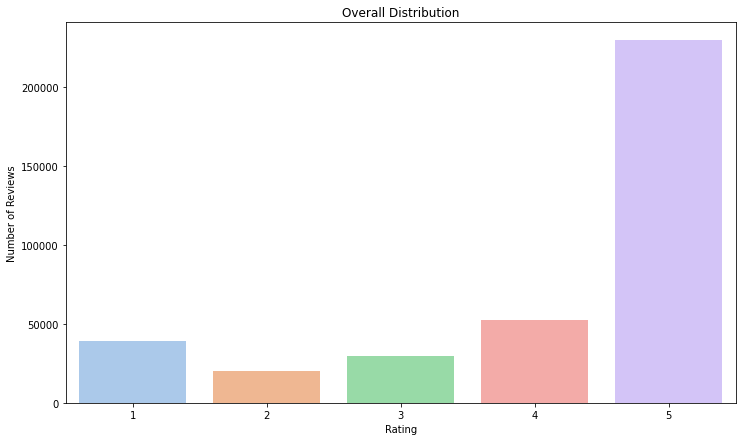

In [16]:
f, axes = plt.subplots(figsize=(12,7))
ax = sns.countplot(x=df["overall"], palette="pastel")
ax.set(title="Overall Distribution", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

### NLP Pre-Processing

In [25]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
pattern = r"\&\#[0-9]+\;"

df["reviewText"] = df["reviewText"].str.replace(pat=pattern, repl="", regex=True)

Dropping duplicated rows and na's.

In [27]:
df.drop_duplicates(subset=['reviewText'],inplace=True)

In [28]:
df['reviewText'].dropna(inplace = True)

In [29]:
df['reviewText'].count()

319643

In [30]:
df['reviewText']=df['reviewText'].apply(str)

### WordNetLemmatizer Sample pos_tag

In [31]:
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
text = df['reviewText'][100]
tokenization = nltk.word_tokenize(text)
tagged_token = pos_tag(tokenization)
for w in tagged_token[:5]:
    print(w)

('Looks', 'VBZ')
('exactly', 'RB')
('the', 'DT')
('same', 'JJ')
('as', 'IN')


### Extracting the root of word with Lemmatization

In [141]:
%%time

lemmatizer = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemmatizer.lemmatize(word, wn.ADJ))
        elif tag.startswith('V'):
            root.append(lemmatizer.lemmatize(word, wn.VERB))
        elif tag.startswith('N'):
            root.append(lemmatizer.lemmatize(word, wn.NOUN))
        elif tag.startswith('R'):
            root.append(lemmatizer.lemmatize(word, wn.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_rev(rev):  
    lemma_list = []
    tokenized_sent = sent_tokenize(rev)
    for sentence in tokenized_sent:
        rem_punctuation = re.sub(r"[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]", " ", sentence)
        tokenized_word = word_tokenize(rem_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemma_list.extend(lemmatized)
    return " ".join(lemma_list)


df["reviewText"] = df["reviewText"].apply(lambda row: lemmatize_rev(row))

CPU times: user 12min 15s, sys: 22.6 s, total: 12min 38s
Wall time: 12min 39s


### Saving lemmatized df in CSV format 

In [279]:
df.to_csv('lemmatized_beauty_final2.csv', index=False)

In [226]:
df_lemmatized = pd.read_csv('lemmatized_beauty_final.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [227]:
df_lemmatized.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,19.02.2015,NaN,NaN,NaN
1,4.0,True,A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband want to read about the Negro Baseba...,... to reading about the Negro Baseball and th...,18.12.2014,NaN,NaN,NaN
2,4.0,True,A1572GUYS7DGSR,0143026860,David G,"This book be very informative , cover all aspe...",Worth the Read,10.08.2014,NaN,NaN,NaN
3,5.0,True,A1PSGLFK1NSVO,0143026860,TamB,I be already a baseball fan and know a bit abo...,Good Read,11.03.2013,NaN,NaN,NaN
4,5.0,True,A6IKXKZMTKGSC,0143026860,shoecanary,This be a good story of the Black league . I b...,"More than facts, a good story read!",25.12.2011,5,NaN,NaN


In [228]:
df_lemmatized["reviewText"][256547]

"The product be suppose to be new . The package have be open before . Now that I have try it , the poor stay quality tell me that this be not the real Dermacol foundation . Other difference be fake have no color number on tube , small lid circumferance & long lid on the fake , real lid have gold fleck appearance , liquid pour out of fake tube upon opening , fake tube 's length be long than real tube . The shade color be not the same as the real Dermacol 221 I purchase from different seller ."

### Converting to Lower Case

In [229]:
df_lemmatized["reviewText"] = df_lemmatized["reviewText"].str.lower()

### Removing the Stop Words

In [230]:
stop_words = stopwords.words("english")

df_lemmatized["reviewText"] = df_lemmatized["reviewText"].apply(str)
        

remove_stop_words = lambda row: " ".join([token for token in row.split(" ") \
                                          if token not in stop_words and len(token) > 2])
df_lemmatized["reviewText"] = df_lemmatized["reviewText"].apply(remove_stop_words)

### Keeping only Alphanumeric Chars and White Spaces and Removing Extra Spaces

In [231]:
df_lemmatized["reviewText"] = df_lemmatized["reviewText"].str.replace(pat=r"[^\w\s]", repl=" ", regex=True)
df_lemmatized["reviewText"] = df_lemmatized["reviewText"].str.replace(pat=r"[\d]", repl=" ", regex=True)
df_lemmatized["reviewText"] = df_lemmatized["reviewText"].str.replace(pat=r"[\s]+", repl=" ", regex=True)
df_lemmatized["reviewText"] = df_lemmatized["reviewText"].str.replace(pat=r"[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]", repl=" ", regex=True)

In [232]:
df_lemmatized["reviewText"][256547]

'product suppose new package open try poor stay quality tell real dermacol foundation difference fake color number tube small lid circumferance long lid fake real lid gold fleck appearance liquid pour fake tube upon opening fake tube length long real tube shade color real dermacol purchase different seller'

### Tokenization

In [201]:
df['reviewText'][300102]

"The product was supposed to be new. The package had been opened before. Now that I have tried it, the poor staying quality tells me that this is not the real Dermacol foundation. Other differences are fake has no color number on tube, smaller lid circumferance & longer lid on the fake, real lid has gold fleck appearance, liquid pours out of fake tube upon opening, fake tube's length is longer than real tube. The shade color is not the same as the real Dermacol 221 I purchased from different seller."

In [202]:
df_lemmatized['reviewText'][256547]

'product suppose new package open try poor stay quality tell real dermacol foundation difference fake color number tube small lid circumferance long lid fake real lid gold fleck appearance liquid pour fake tube upon opening fake tube length long real tube shade color real dermacol 221 purchase different seller'

In [203]:
corpora = df_lemmatized["reviewText"].values
tokenized = [corpus.split(" ") for corpus in corpora]



print(tokenized[256547])

['product', 'suppose', 'new', 'package', 'open', 'try', 'poor', 'stay', 'quality', 'tell', 'real', 'dermacol', 'foundation', 'difference', 'fake', 'color', 'number', 'tube', 'small', 'lid', 'circumferance', 'long', 'lid', 'fake', 'real', 'lid', 'gold', 'fleck', 'appearance', 'liquid', 'pour', 'fake', 'tube', 'upon', 'opening', 'fake', 'tube', 'length', 'long', 'real', 'tube', 'shade', 'color', 'real', 'dermacol', '221', 'purchase', 'different', 'seller']


### Vocabulary Creation

In [204]:
vocabulary = Dictionary(tokenized)

In [205]:
vocabulary.token2id

{'great': 0,
 'addition': 1,
 'baseball': 2,
 'book': 3,
 'haveinformation': 4,
 'husband': 5,
 'library': 6,
 'n': 7,
 'negro': 8,
 'read': 9,
 'start': 10,
 't': 11,
 'tthank': 12,
 'want': 13,
 'aspect': 14,
 'cover': 15,
 'game': 16,
 'informative': 17,
 'already': 18,
 'bit': 19,
 'fan': 20,
 'know': 21,
 'league': 22,
 'learn': 23,
 'lot': 24,
 'reading': 25,
 'adult': 26,
 'also': 27,
 'anyone': 28,
 'audience': 29,
 'black': 30,
 'buy': 31,
 'class': 32,
 'continue': 33,
 'enjoy': 34,
 'exciting': 35,
 'fact': 36,
 'find': 37,
 'good': 38,
 'high': 39,
 'history': 40,
 'interested': 41,
 'mckissack': 42,
 'recommend': 43,
 'school': 44,
 'story': 45,
 'teach': 46,
 'unlike': 47,
 'well': 48,
 'would': 49,
 'write': 50,
 'young': 51,
 'across': 52,
 'america': 53,
 'back': 54,
 'barrier': 55,
 'battle': 56,
 'big': 57,
 'bravely': 58,
 'capable': 59,
 'catch': 60,
 'citizen': 61,
 'color': 62,
 'come': 63,
 'day': 64,
 'diamond': 65,
 'east': 66,
 'even': 67,
 'every': 68,
 'exc

### Bag of Words (BOW)

In [206]:
bow = [vocabulary.doc2bow(doc) for doc in tokenized]

In [207]:
for idx, freq in bow[256547]:
    print(f"Word: {vocabulary.get(idx)}, Freq: {freq}")

Word: color, Freq: 2
Word: number, Freq: 1
Word: tell, Freq: 1
Word: product, Freq: 1
Word: small, Freq: 1
Word: seller, Freq: 1
Word: purchase, Freq: 1
Word: quality, Freq: 1
Word: appearance, Freq: 1
Word: long, Freq: 2
Word: open, Freq: 1
Word: foundation, Freq: 1
Word: stay, Freq: 1
Word: try, Freq: 1
Word: package, Freq: 1
Word: opening, Freq: 1
Word: different, Freq: 1
Word: new, Freq: 1
Word: poor, Freq: 1
Word: suppose, Freq: 1
Word: real, Freq: 4
Word: difference, Freq: 1
Word: lid, Freq: 3
Word: length, Freq: 1
Word: gold, Freq: 1
Word: liquid, Freq: 1
Word: upon, Freq: 1
Word: shade, Freq: 1
Word: pour, Freq: 1
Word: tube, Freq: 4
Word: fake, Freq: 4
Word: fleck, Freq: 1
Word: 221, Freq: 1
Word: dermacol, Freq: 2
Word: circumferance, Freq: 1


### TF-IDF

In [86]:
tfidf = TfidfModel(bow)

for idx, weight in tfidf[bow[256547]]:
    print(f"Word: {vocabulary.get(idx)}, Weight: {weight:.3f}")

Word: , Weight: 0.004
Word: s, Weight: 0.037
Word: color, Weight: 0.105
Word: number, Weight: 0.107
Word: tell, Weight: 0.077
Word: product, Weight: 0.028
Word: small, Weight: 0.059
Word: seller, Weight: 0.088
Word: purchase, Weight: 0.056
Word: quality, Weight: 0.059
Word: appearance, Weight: 0.113
Word: long, Weight: 0.104
Word: open, Weight: 0.082
Word: foundation, Weight: 0.098
Word: stay, Weight: 0.071
Word: try, Weight: 0.048
Word: package, Weight: 0.081
Word: opening, Weight: 0.130
Word: different, Weight: 0.069
Word: new, Weight: 0.068
Word: poor, Weight: 0.105
Word: suppose, Weight: 0.091
Word: real, Weight: 0.343
Word: difference, Weight: 0.075
Word: lid, Weight: 0.314
Word: length, Weight: 0.096
Word: gold, Weight: 0.111
Word: liquid, Weight: 0.097
Word: upon, Weight: 0.113
Word: shade, Weight: 0.099
Word: pour, Weight: 0.126
Word: tube, Weight: 0.383
Word: fake, Weight: 0.438
Word: fleck, Weight: 0.172
Word: dermacol, Weight: 0.364
Word: circumferance, Weight: 0.245


In [87]:
%%time

import numpy as np

from gensim.models import word2vec

np.set_printoptions(suppress=True)


word_vec= word2vec.Word2Vec(tokenized)

CPU times: user 44.2 s, sys: 262 ms, total: 44.5 s
Wall time: 17.9 s


In [88]:
word_vec_unpack = [(word, idx.index) for word, idx in \
                   word_vec.wv.vocab.items()]

In [89]:
tokens, indexes = zip(*word_vec_unpack)

In [98]:
word_vec_df = pd.DataFrame(word_vec.wv.syn0[indexes, :], index=tokens)

word_vec_df.head()

<ipython-input-98-99e0f0396e20>:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  word_vec_df = pd.DataFrame(word_vec.wv.syn0[indexes, :], index=tokens)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
great,-1.201949,0.144700,0.574869,2.752909,-0.388276,-1.574940,0.477391,0.049548,-1.164826,-0.106699,...,1.994949,2.316634,1.655789,1.260824,-0.539082,0.125721,2.736740,-0.253912,0.253270,2.070598
husband,0.044235,-0.624490,0.766864,-0.096014,-1.737497,-1.962552,1.309048,2.582413,-0.380935,0.499077,...,-0.424558,0.666695,0.228896,-0.990749,-2.567177,-0.297132,0.927786,-0.831079,0.003286,-0.183259
want,-1.975531,1.179926,-1.058031,0.623056,-0.554303,1.691741,-0.853700,0.850673,0.688437,-1.651572,...,-0.635158,0.537367,-0.549163,-1.610598,-1.002761,0.335772,1.147842,0.882778,0.275279,0.753868
read,-0.597246,-2.358415,0.198330,-0.574358,-0.256990,0.211905,0.574853,1.306706,-0.310360,-1.215431,...,0.877756,2.454601,-0.734411,-2.043415,2.083447,0.068183,1.553645,-2.957670,-2.572025,-0.265907
negro,0.112753,0.003688,-0.110379,0.157676,0.004753,0.150588,0.081015,0.107179,0.054396,0.117308,...,-0.184214,-0.046896,-0.078399,0.094858,-0.017367,-0.084848,-0.053275,-0.122904,-0.077714,-0.143235


In [91]:
%%time

tokenized_array = np.array(tokenized, dtype='object')

model_array = np.array([word_vec_df.reindex(doc).mean(axis=0) for doc in tokenized_array])

CPU times: user 3min 48s, sys: 942 ms, total: 3min 49s
Wall time: 3min 49s


In [92]:
model_array

array([[-1.2019494 ,  0.1447001 ,  0.57486904, ..., -0.2539117 ,
         0.2532703 ,  2.0705981 ],
       [-0.12247618, -0.27431986, -0.23594823, ..., -0.5968004 ,
        -0.18670075,  0.28634655],
       [-0.13464384, -1.2069293 , -0.5199021 , ..., -0.45948437,
         0.06474627, -0.37650576],
       ...,
       [-1.4163423 ,  0.27495602,  0.72984433, ...,  0.06097759,
        -0.04898139,  0.62465465],
       [-1.660054  , -0.13815938, -0.02870248, ..., -0.30280676,
        -0.43369445, -0.09177174],
       [-0.72361135,  0.05297217, -0.57034373, ..., -0.4685812 ,
        -0.11193252,  0.05097417]], dtype=float32)

In [99]:
model_df = pd.DataFrame(model_array)
model_df["label"] = df_lemmatized["overall"]

model_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-1.201949,0.144700,0.574869,2.752909,-0.388276,-1.574940,0.477391,0.049548,-1.164826,-0.106699,...,2.316634,1.655789,1.260824,-0.539082,0.125721,2.736740,-0.253912,0.253270,2.070598,1.0
1,-0.122476,-0.274320,-0.235948,0.239716,-0.083765,-0.369554,0.212815,0.528531,0.055425,-0.435444,...,0.435009,-0.108200,-0.289259,-0.343994,0.146651,0.861258,-0.596800,-0.186701,0.286347,4.0
2,-0.134644,-1.206929,-0.519902,0.246288,0.966006,0.071862,-0.058469,0.253898,-0.057673,0.014242,...,-0.303036,0.419713,-0.115435,0.591335,-0.121853,0.034238,-0.459484,0.064746,-0.376506,4.0
3,-0.163815,-0.474026,-0.003632,0.119767,0.116645,-0.097260,-0.000558,-0.022949,-0.014875,-0.603142,...,0.135594,-0.182681,-0.557722,0.470839,0.515196,-0.020371,-0.859123,-0.234994,0.189479,5.0
4,-0.157024,-0.151582,-0.406453,-0.000831,-0.129803,-0.177306,-0.096088,0.430276,0.012211,-0.167220,...,0.243920,0.034709,-0.423191,-0.105042,0.078415,0.465685,-0.509353,-0.344450,-0.007182,5.0


In [103]:
model_df = model_df.dropna(axis=0)
model_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-1.201949,0.144700,0.574869,2.752909,-0.388276,-1.574940,0.477391,0.049548,-1.164826,-0.106699,...,2.316634,1.655789,1.260824,-0.539082,0.125721,2.736740,-0.253912,0.253270,2.070598,1.0
1,-0.122476,-0.274320,-0.235948,0.239716,-0.083765,-0.369554,0.212815,0.528531,0.055425,-0.435444,...,0.435009,-0.108200,-0.289259,-0.343994,0.146651,0.861258,-0.596800,-0.186701,0.286347,4.0
2,-0.134644,-1.206929,-0.519902,0.246288,0.966006,0.071862,-0.058469,0.253898,-0.057673,0.014242,...,-0.303036,0.419713,-0.115435,0.591335,-0.121853,0.034238,-0.459484,0.064746,-0.376506,4.0
3,-0.163815,-0.474026,-0.003632,0.119767,0.116645,-0.097260,-0.000558,-0.022949,-0.014875,-0.603142,...,0.135594,-0.182681,-0.557722,0.470839,0.515196,-0.020371,-0.859123,-0.234994,0.189479,5.0
4,-0.157024,-0.151582,-0.406453,-0.000831,-0.129803,-0.177306,-0.096088,0.430276,0.012211,-0.167220,...,0.243920,0.034709,-0.423191,-0.105042,0.078415,0.465685,-0.509353,-0.344450,-0.007182,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319639,-0.850631,0.488832,0.353555,-0.455352,0.184467,-0.161220,-0.997328,-0.835478,-0.969907,-0.592102,...,-0.290564,0.015754,-0.498125,0.408482,0.539643,0.274512,-0.048480,-0.168280,0.766513,1.0
319640,-0.664502,0.423804,0.202708,-0.477428,0.334480,-0.506375,-0.671812,-0.198242,-0.156401,-0.685886,...,0.049857,0.366893,-0.616942,0.002450,0.236297,0.580446,-0.136920,-0.322472,0.553784,5.0
319641,-1.416342,0.274956,0.729844,0.826062,0.608657,-0.790298,-0.626386,-0.139923,-0.056454,-0.818421,...,0.387351,0.423271,-0.512620,0.298065,0.294367,0.965149,0.060978,-0.048981,0.624655,5.0
319642,-1.660054,-0.138159,-0.028702,-0.148238,0.995625,-0.164171,-0.567897,-0.234625,0.055548,-1.027739,...,-0.323886,0.547564,-0.381671,0.742524,-0.410337,0.252027,-0.302807,-0.433694,-0.091772,2.0


### Modelling

In [104]:
from sklearn.model_selection import train_test_split

X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
def classification_metrics(y_test, predict):
    print("Confusion Matrix:\n")
    print(confusion_matrix(y_test, predict))
    print("\nAccuracy: ", accuracy_score(y_test, predict))
    print("\nClassification report:\n")
    print(classification_report(y_test, predict))

### Random Forest

In [106]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
forest.fit(X_train, y_train)

CPU times: user 4min 22s, sys: 796 ms, total: 4min 23s
Wall time: 4min 23s


RandomForestClassifier(class_weight='balanced', random_state=42)

In [107]:
from sklearn import metrics
y_pred = forest.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

classification_metrics(y_train, y_pred)

Training Set Accuracy: 98.833%
Training Set F1 Score: 0.988
Confusion Matrix:

[[ 29062    157     78     37     43]
 [   133  15021     38     17     13]
 [    84     65  21456     49     52]
 [   103     41    111  36145    347]
 [   384    147    222    861 150819]]

Accuracy:  0.9883280818834765

Classification report:

              precision    recall  f1-score   support

         1.0       0.98      0.99      0.98     29377
         2.0       0.97      0.99      0.98     15222
         3.0       0.98      0.99      0.98     21706
         4.0       0.97      0.98      0.98     36747
         5.0       1.00      0.99      0.99    152433

    accuracy                           0.99    255485
   macro avg       0.98      0.99      0.98    255485
weighted avg       0.99      0.99      0.99    255485



In [110]:
predict = forest.predict(X_test)
classification_metrics(y_test, predict)

Confusion Matrix:

[[ 3237    89    93    43  3854]
 [  853    60   104    73  2688]
 [  649    66   230   172  4274]
 [  305    30   140   322  8476]
 [  474    54   123   406 37057]]

Accuracy:  0.640437124248497

Classification report:

              precision    recall  f1-score   support

         1.0       0.59      0.44      0.50      7316
         2.0       0.20      0.02      0.03      3778
         3.0       0.33      0.04      0.08      5391
         4.0       0.32      0.03      0.06      9273
         5.0       0.66      0.97      0.78     38114

    accuracy                           0.64     63872
   macro avg       0.42      0.30      0.29     63872
weighted avg       0.55      0.64      0.54     63872



In [111]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
f1_score = metrics.f1_score(y_test, y_pred_test, average="micro")

print(f"Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Test Set F1 Score: {f1_score:.3f}")

Test Set Accuracy: 64.044%
Test Set F1 Score: 0.640


### ExtraTreesClassifier

In [112]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.ensemble import ExtraTreesClassifier
etC = ExtraTreesClassifier(random_state=0, n_estimators=50)

etC.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=50, random_state=0)

In [114]:
y_pred = etC.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

classification_metrics(y_train, y_pred)

Training Set Accuracy: 99.078%
Training Set F1 Score: 0.991
Confusion Matrix:

[[ 29140     16     25      5    191]
 [   234  14880     27      7     74]
 [   121     38  21370     15    162]
 [    70     15     89  35901    672]
 [   140     29     93    333 151838]]

Accuracy:  0.9907783235806408

Classification report:

              precision    recall  f1-score   support

         1.0       0.98      0.99      0.99     29377
         2.0       0.99      0.98      0.99     15222
         3.0       0.99      0.98      0.99     21706
         4.0       0.99      0.98      0.98     36747
         5.0       0.99      1.00      0.99    152433

    accuracy                           0.99    255485
   macro avg       0.99      0.99      0.99    255485
weighted avg       0.99      0.99      0.99    255485



In [116]:
y_pred_test = etC.predict(X_test)
classification_metrics(y_test, y_pred_test)

Confusion Matrix:

[[ 3249   107   148   125  3687]
 [  922    66   124   159  2507]
 [  693    86   279   381  3952]
 [  351    25   187   516  8194]
 [  437    34   116   454 37073]]

Accuracy:  0.6447739228456913

Classification report:

              precision    recall  f1-score   support

         1.0       0.57      0.44      0.50      7316
         2.0       0.21      0.02      0.03      3778
         3.0       0.33      0.05      0.09      5391
         4.0       0.32      0.06      0.09      9273
         5.0       0.67      0.97      0.79     38114

    accuracy                           0.64     63872
   macro avg       0.42      0.31      0.30     63872
weighted avg       0.55      0.64      0.55     63872



In [117]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
f1_score = metrics.f1_score(y_test, y_pred_test, average="micro")

print(f"Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Test Set F1 Score: {f1_score:.3f}")

Test Set Accuracy: 64.477%
Test Set F1 Score: 0.645


### XGBoost Classifier

In [118]:
from xgboost import XGBClassifier

xgB = XGBClassifier()
xgB.fit(X_train, y_train)
xgb_train_predict = pd.DataFrame(data=xgB.predict(X_train),)
classification_metrics(y_train, xgb_train_predict)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:15:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix:

[[ 21715    288    818    692   5864]
 [  3557   4163   1086   1119   5297]
 [  2557    333   7206   2453   9157]
 [  1429    228   1286   9705  24099]
 [  1875    201   1012   2675 146670]]

Accuracy:  0.741566041059162

Classification report:

              precision    recall  f1-score   support

         1.0       0.70      0.74      0.72     29377
         2.0       0.80      0.27      0.41     15222
         3.0       0.63      0.33      0.44     21706
         4.0       0.58      0.26      0.36     36747
         5.0       0.77      0.96      0.85    152433

    accuracy                           0.74    255485
   macro avg       0.70      0.51      0.56    255485
weighted avg      

In [121]:
accuracy = metrics.accuracy_score(y_train, xgb_train_predict)
f1_score = metrics.f1_score(y_train, xgb_train_predict, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 74.157%
Training Set F1 Score: 0.742


In [119]:
xgb_test_predict = pd.DataFrame(data=xgB.predict(X_test))
classification_metrics(y_test, xgb_test_predict)

Confusion Matrix:

[[ 4529   270   345   228  1944]
 [ 1332   227   444   332  1443]
 [  852   199   889   925  2526]
 [  452    88   562  1528  6643]
 [  718   102   360  1044 35890]]

Accuracy:  0.6742077905811623

Classification report:

              precision    recall  f1-score   support

         1.0       0.57      0.62      0.60      7316
         2.0       0.26      0.06      0.10      3778
         3.0       0.34      0.16      0.22      5391
         4.0       0.38      0.16      0.23      9273
         5.0       0.74      0.94      0.83     38114

    accuracy                           0.67     63872
   macro avg       0.46      0.39      0.39     63872
weighted avg       0.61      0.67      0.62     63872



In [120]:
accuracy = metrics.accuracy_score(y_test, xgb_test_predict)
f1_score = metrics.f1_score(y_test, xgb_test_predict, average="micro")

print(f"Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Test Set F1 Score: {f1_score:.3f}")

Test Set Accuracy: 67.421%
Test Set F1 Score: 0.674


In [126]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [127]:
y_pred = dec_tree.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

classification_metrics(y_train, y_pred)

Training Set Accuracy: 98.695%
Training Set F1 Score: 0.987
Confusion Matrix:

[[ 29053    185     84     29     26]
 [   116  15058     27     10     11]
 [    73     79  21483     41     30]
 [   112     56    130  36245    204]
 [   440    156    336   1188 150313]]

Accuracy:  0.9869542243184531

Classification report:

              precision    recall  f1-score   support

         1.0       0.98      0.99      0.98     29377
         2.0       0.97      0.99      0.98     15222
         3.0       0.97      0.99      0.98     21706
         4.0       0.97      0.99      0.98     36747
         5.0       1.00      0.99      0.99    152433

    accuracy                           0.99    255485
   macro avg       0.98      0.99      0.98    255485
weighted avg       0.99      0.99      0.99    255485



In [128]:
predict = dec_tree.predict(X_test)
classification_metrics(y_test, predict)

Confusion Matrix:

[[ 2534   920   897   798  2167]
 [  862   507   521   523  1365]
 [  843   597   847   980  2124]
 [  820   632  1062  1826  4933]
 [ 2250  1490  2327  5416 26631]]

Accuracy:  0.5064034318637275

Classification report:

              precision    recall  f1-score   support

         1.0       0.35      0.35      0.35      7316
         2.0       0.12      0.13      0.13      3778
         3.0       0.15      0.16      0.15      5391
         4.0       0.19      0.20      0.19      9273
         5.0       0.72      0.70      0.71     38114

    accuracy                           0.51     63872
   macro avg       0.31      0.31      0.31     63872
weighted avg       0.51      0.51      0.51     63872



### Dealing with Unbalanced Data

In [129]:
majority = len(df_lemmatized[df_lemmatized["overall"] == 5]) / len(df_lemmatized)

round(majority,3)

0.597

In [130]:
count = len(model_df[model_df["label"] == 2])
#trim the majority class
condition = model_df["label"] == 5
balanced_df = model_df[condition].sample(n=count, random_state=42)

#trim other class and add on to the trimmed_df
for rating in [1, 2, 3, 4]:
    condition = model_df["label"] == rating
    if len(model_df[condition]) >= count:
        add_df = model_df[condition].sample(n=count, random_state=42)
    else:
        add_df = model_df[condition]
    balanced_df = pd.concat([balanced_df, add_df], ignore_index=False)

#display new class sizes of trimmed_df
for rating in [1, 2, 3, 4, 5]:
    class_size = len(balanced_df[balanced_df["label"] == rating])
    print(f"Size of Class {rating}: {class_size}")

Size of Class 1: 19000
Size of Class 2: 19000
Size of Class 3: 19000
Size of Class 4: 19000
Size of Class 5: 19000


In [149]:
balanced_df.count()

0        95000
1        95000
2        95000
3        95000
4        95000
         ...  
96       95000
97       95000
98       95000
99       95000
label    95000
Length: 101, dtype: int64

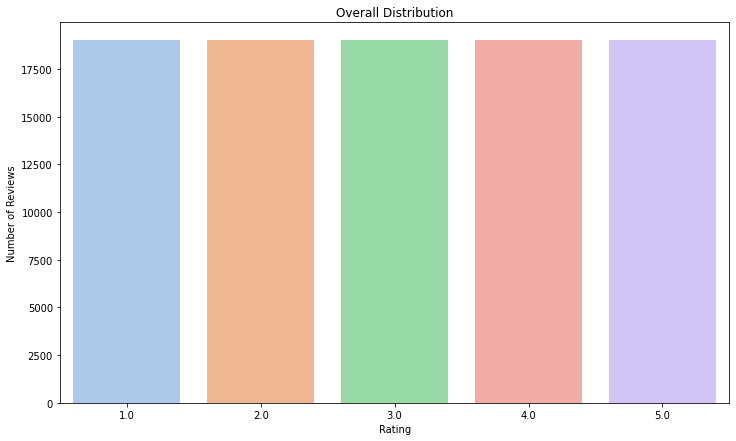

In [133]:
f, axes = plt.subplots(figsize=(12,7))
ax = sns.countplot(x=balanced_df["label"], palette="pastel")
ax.set(title="Overall Distribution", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

In [139]:
X = balanced_df.iloc[:, :-1]
y = balanced_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42, shuffle=True)

In [140]:
xgB = XGBClassifier()
xgB.fit(X_train, y_train)
xgb_train_predict = pd.DataFrame(data=xgB.predict(X_train))
classification_metrics(y_train, xgb_train_predict)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:41:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix:

[[12791   900   741   438   330]
 [ 1596 10821  1180  1062   541]
 [ 1008  1275 10474  1603   840]
 [  463   753  1042 11240  1702]
 [  286   380   469  1132 12933]]

Accuracy:  0.7665657894736843

Classification report:

              precision    recall  f1-score   support

         1.0       0.79      0.84      0.82     15200
         2.0       0.77      0.71      0.74     15200
         3.0       0.75      0.69      0.72     15200
         4.0       0.73      0.74      0.73     15200
         5.0       0.79      0.85      0.82     15200

    accuracy                           0.77     76000
   macro avg       0.77      0.77      0.77     76000
weighted avg       0.77      0.77      0.7

In [141]:
xgb_test_predict = pd.DataFrame(data=xgB.predict(X_test))
classification_metrics(y_test, xgb_test_predict)

Confusion Matrix:

[[2197  885  357  174  187]
 [1070 1200  829  453  248]
 [ 518  911 1135  857  379]
 [ 198  396  666 1464 1076]
 [ 173  207  230  784 2406]]

Accuracy:  0.4422105263157895

Classification report:

              precision    recall  f1-score   support

         1.0       0.53      0.58      0.55      3800
         2.0       0.33      0.32      0.32      3800
         3.0       0.35      0.30      0.32      3800
         4.0       0.39      0.39      0.39      3800
         5.0       0.56      0.63      0.59      3800

    accuracy                           0.44     19000
   macro avg       0.43      0.44      0.44     19000
weighted avg       0.43      0.44      0.44     19000



### Deep Learning - LSTM

In [567]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 16
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_lemmatized['reviewText'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 67930 unique tokens.


In [568]:
X = tokenizer.texts_to_sequences(df_lemmatized['reviewText'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (319644, 250)


In [569]:
Y = df_lemmatized['overall'].to_frame()
        
conditions = [
    (Y['overall'] == 1.0),
    (Y['overall'] == 2.0),
    (Y['overall'] == 3.0),
    (Y['overall'] == 4.0),
    (Y['overall'] == 5.0)
    ]

# create a list of the values we want to assign for each condition
values = ['bad', 'notbad', 'neutral', 'good', 'verygood']

# create a new column and use np.select to assign values to it using our lists as arguments
Y['label'] = np.select(conditions, values)

In [570]:
Y = pd.get_dummies(Y['label']).values

In [571]:
from tensorflow.keras.utils import to_categorical

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(287679, 250) (287679, 5)
(31965, 250) (31965, 5)


In [460]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(16))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
4046/4046 [==============================] - 230s 57ms/step - loss: 0.9365 - accuracy: 0.6584 - val_loss: 0.8033 - val_accuracy: 0.6967
Epoch 2/5
4046/4046 [==============================] - 231s 57ms/step - loss: 0.7735 - accuracy: 0.7078 - val_loss: 0.7951 - val_accuracy: 0.6990
Epoch 3/5
4046/4046 [==============================] - 235s 58ms/step - loss: 0.7270 - accuracy: 0.7227 - val_loss: 0.8095 - val_accuracy: 0.7003
Epoch 4/5
4046/4046 [==============================] - 235s 58ms/step - loss: 0.6907 - accuracy: 0.7370 - val_loss: 0.8213 - val_accuracy: 0.6978
Epoch 5/5
4046/4046 [==============================] - 236s 58ms/step - loss: 0.6560 - accuracy: 0.7500 - val_loss: 0.8299 - val_accuracy: 0.6966


In [461]:
model.save('lstm_model.h5') 

In [462]:
ypred= model.predict(X_test)

In [463]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

999/999 [==============================] - 9s 9ms/step - loss: 0.8258 - accuracy: 0.6963
Test set
  Loss: 0.826
  Accuracy: 0.696


In [490]:
yhat_classes = model.predict_classes(X_test, verbose=0)
rounded_labels=np.argmax(Y_test, axis=1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [491]:
classification_metrics(rounded_labels, yhat_classes)

Confusion Matrix:

[[ 2520    50   276   221   644]
 [  162   941   467    42  2947]
 [  412   378   764   169   919]
 [  737    94   386   209   496]
 [  294   685   293    35 17824]]

Accuracy:  0.6963241044892852

Classification report:

              precision    recall  f1-score   support

           0       0.61      0.68      0.64      3711
           1       0.44      0.21      0.28      4559
           2       0.35      0.29      0.32      2642
           3       0.31      0.11      0.16      1922
           4       0.78      0.93      0.85     19131

    accuracy                           0.70     31965
   macro avg       0.50      0.44      0.45     31965
weighted avg       0.65      0.70      0.66     31965



### Deep Learning - LSTM + CNN

In [550]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(50000, 16, input_length=250))
model.add(Conv1D(filters=64, kernel_size = 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(16))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_105 (Embedding)    (None, 250, 16)           800000    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 248, 64)           3136      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 124, 64)           0         
_________________________________________________________________
lstm_99 (LSTM)               (None, 16)                5184      
_________________________________________________________________
flatten_35 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 512)               8704      
_________________________________________________________________
dense_160 (Dense)            (None, 5)              

In [551]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=64,validation_split=0.1)

Epoch 1/10
4046/4046 [==============================] - 153s 38ms/step - loss: 0.9382 - accuracy: 0.6582 - val_loss: 0.7938 - val_accuracy: 0.6992
Epoch 2/10
4046/4046 [==============================] - 152s 38ms/step - loss: 0.7607 - accuracy: 0.7109 - val_loss: 0.7918 - val_accuracy: 0.7006
Epoch 3/10
4046/4046 [==============================] - 152s 37ms/step - loss: 0.7047 - accuracy: 0.7293 - val_loss: 0.8063 - val_accuracy: 0.6964
Epoch 4/10
4046/4046 [==============================] - 151s 37ms/step - loss: 0.6588 - accuracy: 0.7487 - val_loss: 0.8232 - val_accuracy: 0.6857
Epoch 5/10
4046/4046 [==============================] - 149s 37ms/step - loss: 0.6120 - accuracy: 0.7669 - val_loss: 0.8518 - val_accuracy: 0.6942
Epoch 6/10
4046/4046 [==============================] - 153s 38ms/step - loss: 0.5794 - accuracy: 0.7806 - val_loss: 0.8963 - val_accuracy: 0.6815
Epoch 7/10
4046/4046 [==============================] - 154s 38ms/step - loss: 0.5468 - accuracy: 0.7958 - val_loss: 0

In [552]:
model.save('lstm_cnn_model.h5') 

In [553]:
yhat_classes = model.predict_classes(X_test, verbose=0)
rounded_labels=np.argmax(Y_test, axis=1)

classification_metrics(rounded_labels, yhat_classes)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion Matrix:

[[ 2469   102   361   273   506]
 [  169  1243   615    75  2457]
 [  409   517   844   185   687]
 [  739   152   439   219   373]
 [  386  1553   537   102 16553]]

Accuracy:  0.6672297825746911

Classification report:

              precision    recall  f1-score   support

           0       0.59      0.67      0.63      3711
           1       0.35      0.27      0.31      4559
           2       0.30      0.32      0.31      2642
           3       0.26      0.11      0.16      1922
           4       0.80      0.87      0.83     19131

    accuracy                           0.67     31965
   macro avg       0.46      0.45      0.45     31965
weighted avg       0.64      0.67      0.65     31965



## Exploratory Data Analysis

### LDA and Topic Modelling

In [208]:
%%time
import multiprocessing

from gensim.models.ldamulticore import LdaMulticore

cores = multiprocessing.cpu_count()

num_topics = 10
bow_lda = LdaMulticore(bow, num_topics=num_topics, id2word=vocabulary, \
                       passes=5, workers=cores, random_state=42)

for token, frequency in bow_lda.show_topic(0, topn=5):
    print(token, frequency)

hair 0.057137743
use 0.03659064
product 0.022688037
work 0.01836899
t 0.0162057
CPU times: user 1min 7s, sys: 15.8 s, total: 1min 23s
Wall time: 1min 34s


In [209]:
#Emrenin anlattığı gibi bow kullanıldığı için kelimelerin anlamları
#kaybolabiliyor veya eş anlamlılar olursa tespit zor olabiliyor
for topic in range(0, num_topics):
    print(f"\nTopic {topic+1}:")
    for token, frequency in bow_lda.show_topic(topic, topn=5):
        print(f" {token} {frequency}")


Topic 1:
 hair 0.05713774263858795
 use 0.036590639501810074
 product 0.022688036784529686
 work 0.01836898922920227
 t 0.016205700114369392

Topic 2:
 t 0.049344129860401154
 n 0.04901977628469467
 product 0.03307762369513512
 get 0.014365723356604576
 buy 0.013248815201222897

Topic 3:
 hair 0.04396681860089302
 t 0.022642631083726883
 n 0.022480880841612816
 get 0.015244336798787117
 use 0.015058043412864208

Topic 4:
 brush 0.025476820766925812
 razor 0.024815315380692482
 shave 0.024490581825375557
 use 0.014448480680584908
 shaver 0.013407531194388866

Topic 5:
 use 0.02587071806192398
 n 0.017022639513015747
 t 0.017021844163537025
 one 0.012683774344623089
 teeth 0.011737131513655186

Topic 6:
 look 0.015447891317307949
 make 0.014532185159623623
 get 0.013522359542548656
 use 0.012344281189143658
 like 0.011958295479416847

Topic 7:
 love 0.05064253881573677
 use 0.02666466124355793
 great 0.022818630561232567
 one 0.017748015001416206
 year 0.017409350723028183

Topic 8:
 us

In [219]:
word_vec.wv.most_similar('shave', topn=5)

[('shaving', 0.8168691992759705),
 ('shaves', 0.735748291015625),
 ('razor', 0.6707531213760376),
 ('shaver', 0.5992351770401001),
 ('blade', 0.5751073360443115)]

In [223]:
word_vec.wv.similarity('shave', 'razor')

0.6707531

In [217]:
word_vec.wv.similarity('boy', 'girl')

0.60577476

In [213]:
word_bank = ["blade", "skin", "hair", "shampoo", "eye", "parfume", "lip", "fruit", "pencil", "wave", "teeth"]

for word in word_bank[:]:
    related_vec = word_vec.wv.most_similar(word, topn=5)
    related_words = np.array(related_vec)[:,0]
    word_bank.extend(related_words)
    print(f"{word}: {related_words}")

blade: ['blades' 'razor' 'feathers' 'cartridge' 'mach']
skin: ['face' 'complexion' 'flaky' 'redness' 'rosacea']
hair: ['wavy' 'frizzy' 'curly' 'curl' 'strand']
shampoo: ['conditioner' 'detangler' 'poo' 'pantene' 'dandruff']
eye: ['eyes' 'eyelid' 'undereye' 'crease' 'wrinkle']
parfume: ['perry' 'prada' 'fragrence' 'flavors' 'amor']
lip: ['lips' 'chapstick' 'lipstick' 'chap' 'lipgloss']
fruit: ['cinnamon' 'rosemary' 'grape' 'chamomile' 'melon']
pencil: ['liner' 'sharpener' 'eyeliner' 'eyeshadow' 'palette']
wave: ['curl' 'curls' 'bouncy' 'wavy' 'frizz']
teeth: ['tooth' 'gum' 'molar' 'tray' 'mouth']


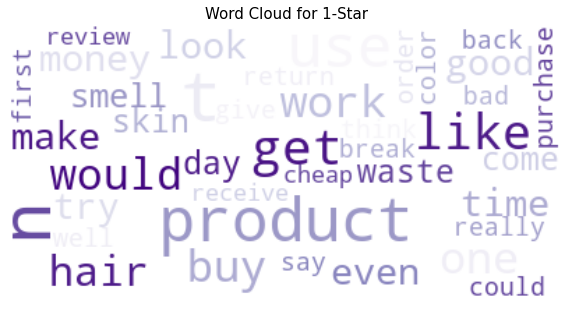

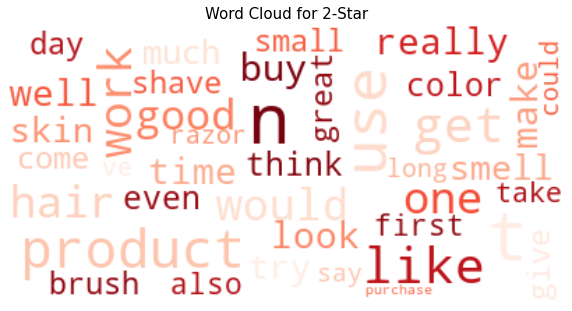

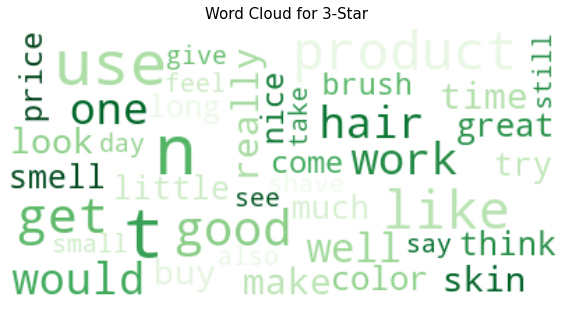

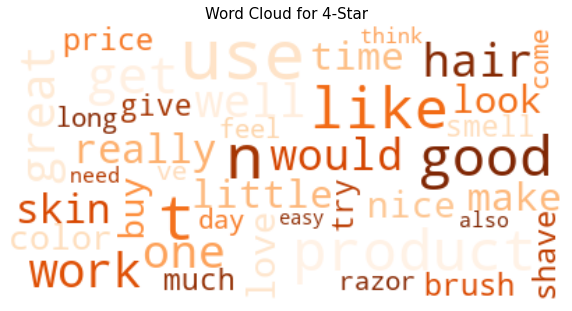

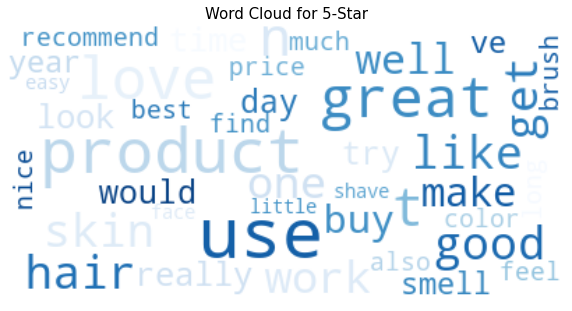

In [214]:
from wordcloud import WordCloud
from collections import Counter

overall_1 = " ".join(df_lemmatized[df_lemmatized["overall"]==1]["reviewText"].values)
overall_2 = " ".join(df_lemmatized[df_lemmatized["overall"]==2]["reviewText"].values)
overall_3 = " ".join(df_lemmatized[df_lemmatized["overall"]==3]["reviewText"].values)
overall_4 = " ".join(df_lemmatized[df_lemmatized["overall"]==4]["reviewText"].values)
overall_5 = " ".join(df_lemmatized[df_lemmatized["overall"]==5]["reviewText"].values)

text_list = [overall_1, overall_2, overall_3, \
             overall_4, overall_5]

for index, text in enumerate(text_list):
    
    colors = ['Purples', 'Reds', 'Greens', 'Oranges', 'Blues']
    
    wordcloud = WordCloud(stopwords = stop_words, min_font_size=10, \
                      max_font_size=50, max_words=40, \
                      background_color="white", colormap = f"{colors[index]}")
    f, axes = plt.subplots(figsize=(10,8))
    c= Counter(text.split(' '))
    wordcloud.generate_from_frequencies(c)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for {index+1}-Star", fontsize=15)
    plt.axis("off")
    plt.show()

# Thanks !